# Temporal networks

In this notebook we show how to perform some basic operations on temporal graphs, reproducing the main plots appearing in the notes. Besides the classical packages, we will deploy some functions that are contained in the `Tnet.py` file whose content of this file is provided in the next notebook. If you want to run this notebook, create a folder named `src`, and add a file named `Tnet.py` with the codes insde of it.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from collections import Counter
import matplotlib.pyplot as plt
import sys
from copy import copy

# np.set_printoptions(legacy='1.25')

sys.path.append('../')
from src.Tnet import *

## Activity driven

In [2]:
def ActivityDriven(n, x, η, m, T, verbose = True):
    '''Generates an instance of the activty driven model
    
    Use: dfttau, el = ActivityDriven(n, x, η, m, T)
    
    Inputs:
        * n (int): number of nodes
        * x (array): activity potentials
        * η (float): activity parameter
        * m (int): number of edges per node
        * T (int): number of snapshots

    Optional inputs:
        *verbose (bool): is True (default) is prints the progress

    Output:
        * dfttau (pandas DataFrame): temporal graph in the format i, j, t, τ
        * el (dictionary): The keys are edge (i,j) with i < j and the entries are lists of lists in the format [t_i, t_f], where t_i denotes the beginning of an interaction and t_f the end. Note that t_f - t_i >= 1. 
    '''

    # initialize the dictionary containing the contact timelines of each edge. 
    el = dict()

    for t in range(T):
        if verbose:
            print(f'{int((t+1)*100/T)}%', end = '\r')

        # choose which nodes are active at a particular time-step
        active = np.where(np.random.binomial(1, η*x) == 1)[0]

        for u in active:
            # select the neighbors of the active nodes and add the contacts
            # choose the neighbor among all nodes except u
            neighbors = np.random.choice(list(set(np.arange(n)) - set([u])), m, replace = False)
            for v in neighbors:
                el = _add_contact(el, u, v, t)

    # convert to the ijttau format
    el_ = []

    for e in el.keys():
        i, j = e
        for tt in el[e]:
            el_.append([i, j, tt[0], tt[1]-tt[0]])

    # construct the dataframe in the form ijttau
    dfttau = pd.DataFrame(el_, columns = ['i', 'j', 't', 'τ'])

    return dfttau, el


def _add_contact(el, u, v, t):
    '''This function adds a contact to the dictionary el'''

    # write the edge (u,v) so that u < v
    e = tuple([np.min([u, v]), np.max([u, v])])

    
    if e in el.keys():
        # if the contact is ongoing, increase its duration
        if el[e][-1][1] == t:
            el[e][-1][1] = t+1
        else:
            # if the contact is not ongoing create a new one
            el[e].append([t, t+1])
    
    else:
        # if e is not in the dictionary, add it and set the contact duration to 1
        el[e] = [[t, t+1]]

    return el


def getInterEvent(el):
    '''This function computes the inter-event statistics from the dictionary el'''

    ied = []

    for e in el.keys():
        
        if len(el[e]) > 1:
            for i in range(len(el[e])-1):
                ied.append(el[e][i+1][0] - el[e][i][1])

    return np.array(ied)



In [3]:
n = 1000 # number of nodes

# activity potential
x = np.random.negative_binomial(1, 0.1, n).astype(float)
x /= np.max(x)

η = 0.3 # activity parameter
m = 4 # number of fired edges per node
T = 500 # number of time steps

# generate the graph
dfttau, el = ActivityDriven(n, x, η, m, T)

Activity potential distribution


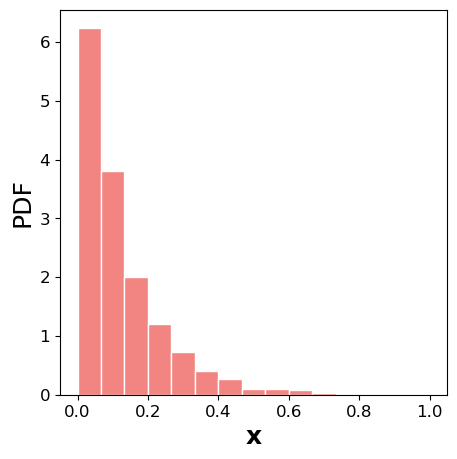

In [4]:
print('Activity potential distribution')

fig, ax = plt.subplots(1,1, figsize = (5, 5))
ax.hist(x, bins = 15, density = True, color = '#f28482', edgecolor = 'white')
ax.tick_params(axis = 'both', labelsize = 12)
ax.set_xlabel(r'$\mathbf{x}$', fontsize = 18)
ax.set_ylabel('PDF', fontsize = 18)
plt.show();

In [ ]:
# aggregated graph
df_agg = dfttau.groupby(['i', 'j']).sum().reset_index()[['i', 'j', 'τ']]
W = csr_matrix((df_agg.τ, (df_agg.i, df_agg.j)), shape = (n, n))
W = W + W.T

# strenght vector
s = W@np.ones(n)

# degree vector
d = W.sign()@np.ones(n)

# contact duration
cd = dfttau.τ.values

# interevent distribution
ied = getInterEvent(el)
s, m = np.std(ied), np.mean(ied)
print(f'Burstiness: {(s_-m)/(s_+m)}')

Burstiness: -0.15753030136770274


Text(0.5, 0, '${\\rm log}(\\Delta \\tau)$')

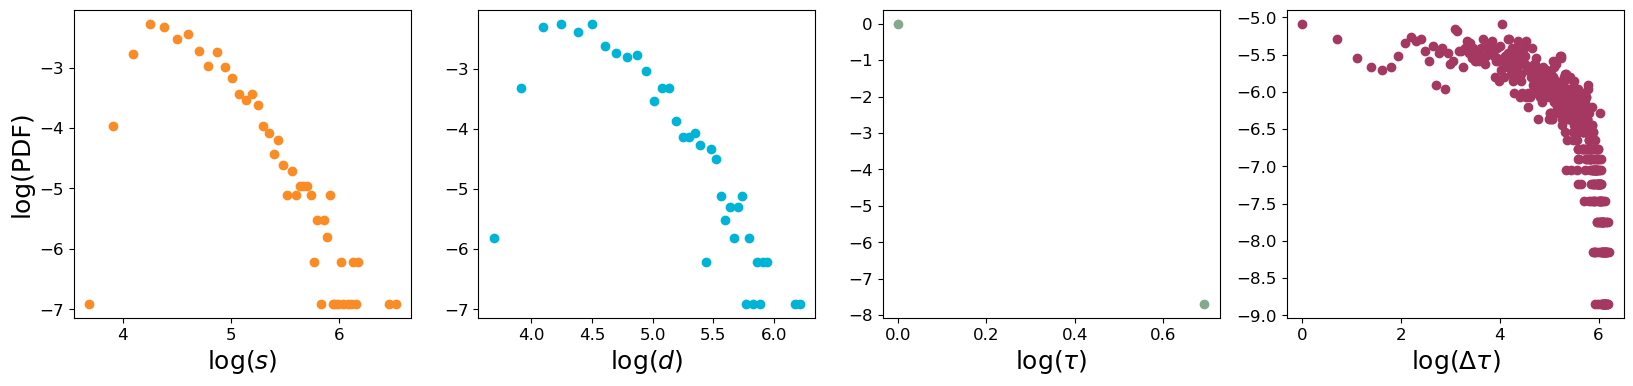

In [ ]:
fig, ax = plt.subplots(1, 4, figsize = (20, 4))

# strength distribution
tres = 10
Dc = Counter(tres*(s/tres).astype(int))
x, y = np.array(list(Dc.keys())), np.array(list(Dc.values()))
ax[0].scatter(np.log(x), np.log(y/np.sum(y)), color = '#fb8b24')
ax[0].tick_params(axis = 'both', labelsize = 12)
ax[0].set_xlabel(r'${\rm log}(s)$', fontsize = 18)
ax[0].set_ylabel('log(PDF)', fontsize = 18)



# degree distribution
tres = 10
Dc = Counter(tres*(d/tres).astype(int))
x, y = np.array(list(Dc.keys())), np.array(list(Dc.values()))
ax[1].scatter(np.log(x), np.log(y/np.sum(y)), color = '#00b4d8')
ax[1].tick_params(axis = 'both', labelsize = 12)
ax[1].set_xlabel(r'${\rm log}(d)$', fontsize = 18)


# duration distribution
tres = 1
Dc = Counter(tres*(cd/tres).astype(int))
x, y = np.array(list(Dc.keys())), np.array(list(Dc.values()))
ax[2].scatter(np.log(x), np.log(y/np.sum(y)), color = '#84a98c')
ax[2].tick_params(axis = 'both', labelsize = 12)
ax[2].set_xlabel(r'${\rm log}(\tau)$', fontsize = 18)

# inter-event distribution
tres = 1
Dc = Counter(tres*(ied/tres).astype(int))
x, y = np.array(list(Dc.keys())), np.array(list(Dc.values()))
ax[3].scatter(np.log(x), np.log(y/np.sum(y)), color = '#a53860')
ax[3].tick_params(axis = 'both', labelsize = 12)
ax[3].set_xlabel(r'${\rm log}(\Delta \tau)$', fontsize = 18)
plt.show();

# Starnini

In [13]:
def ActractivenessModel(n, L, a, rv, step, r, T, verbose = True):
    '''This function generates an instance of the attractiveness model

    Use: dft, el = ActractivenessModel(n, L, a, rv, step, r, T, verbose = True)
    
    Inputs:
        * n (int): number of nodes
        * L (float): box size
        * a (array): attractivity parameters
        * rv (array): activity vector
        * step (float): length of a step in the movement
        * r (float): radius that defines proximity
        * T (int): number of time-steps

    Optional inputs:
        * verbose (bool): if True (default) the function prints the the progress

    Outputs:
        * dfttau (pandas DataFrame): temporal graph in the format i, j, t, τ
        * el (dictionary): The keys are edge (i,j) with i < j and the entries are lists of lists in the format [t_i, t_f], where t_i denotes the beginning of an interaction and t_f the end. Note that t_f - t_i >= 1. 
    '''

    # initialize the positions of the agents
    xpos = np.random.uniform(0, L, n)
    ypos = np.random.uniform(0, L, n)

    # initialize the dictionary containing the contact timelines of each edge. The keys are edge (i,j) with i < j and the entries are lists of lists in the format
    # [t_i, t_f], where t_i denotes the beginning of an interaction and t_f the end. Note that t_f - t_i >= 1.
    el = dict()

    for t in range(T):
        if verbose:
            print(f'{int((t+1)/T*100)}%', end = '\r')

        # probability of not moving
        p_not_move = np.zeros(n)

        # identify active nodes
        active_nodes = np.where(np.random.binomial(1, rv) == 1)[0]


        for i in active_nodes:
            for j in active_nodes:
                if i < j:
                    # check the distance
                    if (xpos[i] - xpos[j])**2 + (ypos[i] - ypos[j])**2 < r**2:
                        
                        # add the temporal edge
                        el = _add_contact(el, i, j, t)

                        # update the probability of moving 
                        p_not_move[i] = np.max([p_not_move[i], a[j]])
                        p_not_move[j] = np.max([p_not_move[j], a[i]])

        # move the agents
        move = np.where(np.random.binomial(1, 1-p_not_move) == 1)[0]
        theta = np.random.uniform(0, 2*np.pi, len(move))
        xpos[move] += step*np.cos(theta)
        ypos[move] += step*np.sin(theta)

        # apply PBC
        xpos[xpos > L] -= L
        xpos[xpos < 0] += L
        ypos[ypos > L] -= L
        ypos[ypos < 0] += L

    # convert to the ijttau format
    el_ = []

    for e in el.keys():
        i, j = e
        for tt in el[e]:
            el_.append([i, j, tt[0], tt[1]-tt[0]])

    # construct the dataframe in the form ijttau
    dfttau = pd.DataFrame(el_, columns = ['i', 'j', 't', 'τ'])

    return dfttau, el

        

In [39]:
n = 500 # number of nodes
L = 1 # box size
step = 0.01 # movement step
r = 0.03 # proximity threshold
T = 500 # number of time steps

# attractivity parameters
a = np.random.negative_binomial(1, 0.1, n).astype(float)
a = a/np.max(a)

rv = np.random.uniform(0,1,n) # activity parameters

# generate the model
dfttau, el = ActractivenessModel(n, L, a, rv, step, r, T, verbose = True)

In [40]:
# aggregated graph
df_agg = dfttau.groupby(['i', 'j']).sum().reset_index()[['i', 'j', 'τ']]
W = csr_matrix((df_agg.τ, (df_agg.i, df_agg.j)), shape = (n, n))
W = W + W.T

# strenght vector
s = W@np.ones(n)

# degree vector
d = W.sign()@np.ones(n)

# contact duration
cd = dfttau.τ.values

# interevent distribution
ied = getInterEvent(el)
s_, m = np.std(ied), np.mean(ied)
print(f'Burstiness: {(s_-m)/(s_+m)}')

Burstiness: 0.4169060916169166


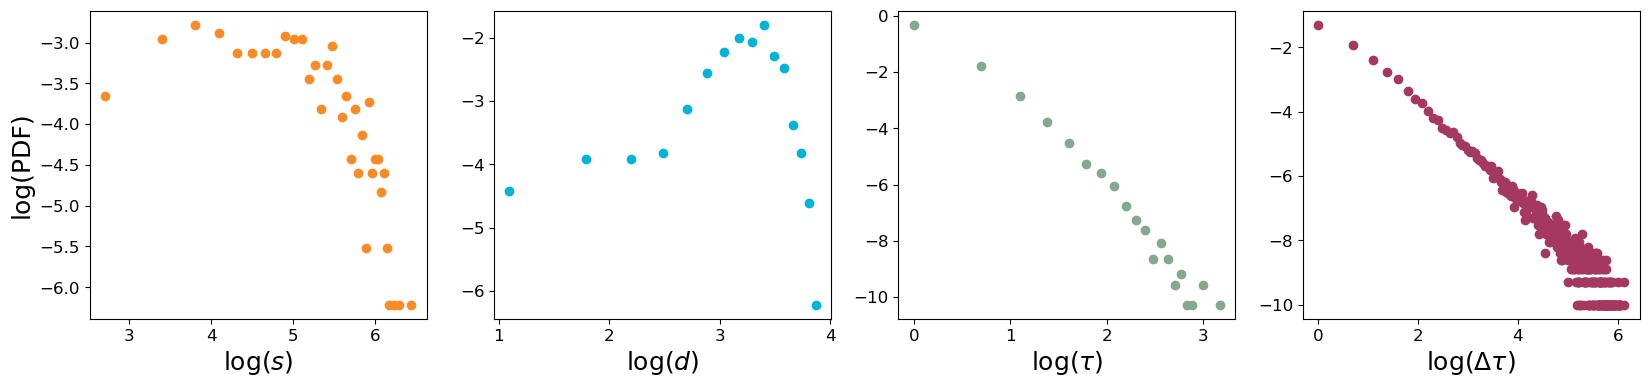

In [49]:
fig, ax = plt.subplots(1, 4, figsize = (20, 4))

# strength distribution
tres = 15
Dc = Counter(tres*(s/tres).astype(int))
x, y = np.array(list(Dc.keys())), np.array(list(Dc.values()))
ax[0].scatter(np.log(x), np.log(y/np.sum(y)), color = '#fb8b24')
ax[0].tick_params(axis = 'both', labelsize = 12)
ax[0].set_xlabel(r'${\rm log}(s)$', fontsize = 18)
ax[0].set_ylabel('log(PDF)', fontsize = 18)



# degree distribution
tres = 3
Dc = Counter(tres*(d/tres).astype(int))
x, y = np.array(list(Dc.keys())), np.array(list(Dc.values()))
ax[1].scatter(np.log(x), np.log(y/np.sum(y)), color = '#00b4d8')
ax[1].tick_params(axis = 'both', labelsize = 12)
ax[1].set_xlabel(r'${\rm log}(d)$', fontsize = 18)


# duration distribution
tres = 1
Dc = Counter(tres*(cd/tres).astype(int))
x, y = np.array(list(Dc.keys())), np.array(list(Dc.values()))
ax[2].scatter(np.log(x), np.log(y/np.sum(y)), color = '#84a98c')
ax[2].tick_params(axis = 'both', labelsize = 12)
ax[2].set_xlabel(r'${\rm log}(\tau)$', fontsize = 18)

# inter-event distribution
tres = 1
Dc = Counter(tres*(ied/tres).astype(int))
x, y = np.array(list(Dc.keys())), np.array(list(Dc.values()))
ax[3].scatter(np.log(x), np.log(y/np.sum(y)), color = '#a53860')
ax[3].tick_params(axis = 'both', labelsize = 12)
ax[3].set_xlabel(r'${\rm log}(\Delta \tau)$', fontsize = 18)
plt.show();